In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from torch.utils.data import DataLoader

In [76]:
BATCH_SIZE = 128

## transformations
transform = transforms.Compose([
    transforms.ToTensor()
    ])

train_dataset = torchvision.datasets.ImageFolder(root='./testpieces', transform=transform)
valid_dataset = torchvision.datasets.ImageFolder(root='./validpieces', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

In [77]:
print('Training Dataset: \n', train_dataset)
print('\nTest Dataset: \n', valid_dataset)

Training Dataset: 
 Dataset ImageFolder
    Number of datapoints: 32000
    Root location: ./testpieces
    StandardTransform
Transform: Compose(
               ToTensor()
           )

Test Dataset: 
 Dataset ImageFolder
    Number of datapoints: 16000
    Root location: ./validpieces
    StandardTransform
Transform: Compose(
               ToTensor()
           )


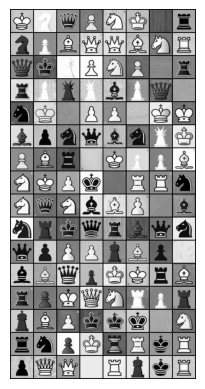

In [78]:
import matplotlib.pyplot as plt
import numpy as np

## get some random training images
images, labels = next(iter(train_loader))

## show images
images_grid = torchvision.utils.make_grid(images)
plt.imshow(np.transpose(images_grid.numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

In [79]:
for images, labels in train_loader:
    print("Train - image batch dimensions:", images.shape)
    print("Train - image label dimensions:", labels.shape)
    break

for images, labels in valid_loader:
    print("valid - image batch dimensions:", images.shape)
    print("valid - image label dimensions:", labels.shape)
    break

Train - image batch dimensions: torch.Size([128, 3, 52, 52])
Train - image label dimensions: torch.Size([128])
valid - image batch dimensions: torch.Size([128, 3, 52, 52])
valid - image label dimensions: torch.Size([128])


In [80]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()

        self.conv_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.fc_layer1 = nn.Linear(50 * 50 * 32, 128)
        self.fc_layer2 = nn.Linear(128, 13)

    def forward(self, x):
        # input: 32x1x28x28 -> output: 32x32x26x26
        x = self.conv_layer(x)
        x = F.relu(x)

        # input: 32x32x26x26 -> output: 32x(32*26*26)
        x = x.flatten(start_dim = 1)

        # input: 32x(32*26*26) -> output: 32x128
        x = self.fc_layer1(x)
        x = F.relu(x)

        # input: 32x128 -> output: 32x10 (32 images, 13 classes)
        x = self.fc_layer2(x)
        out = F.softmax(x, dim=1)
        return out

In [81]:
model = SimpleModel()
for images, labels in train_loader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([128, 3, 52, 52])
torch.Size([128, 13])


In [82]:
def train_model(model, loss_fn, optimizer, data_loader, num_epochs, device):

  for epoch in range(num_epochs):
    train_loss = 0.0
    train_corr, train_n = 0, 0

    model.train()
    for i, (images, labels) in enumerate(data_loader):
        
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()     # zero the gradients (by default it adds up)

      ## forward + backprop + loss
      outputs = model(images)
      loss = loss_fn(outputs, labels)
      loss.backward()

      ## update model params
      optimizer.step()

      _, preds = torch.max(outputs, 1)
      train_corr += torch.sum(preds == labels).item()
      train_n += labels.size(0)

      train_loss += loss.item()
    
    print('Epoch: %d | Loss: %.4f | Train Acc: %.2f%%' \
          %(epoch, train_loss / i, train_corr / train_n * 100))
      
  return model

In [83]:
learning_rate = 0.005
num_epochs = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleModel()
model = model.to(device)

## loss function
loss_fn = nn.CrossEntropyLoss()
## optimization
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

device

device(type='cuda')

In [84]:
model = train_model(model, loss_fn, optimizer, train_loader, num_epochs, device)

Epoch: 0 | Loss: 2.1713 | Train Acc: 55.50%
Epoch: 1 | Loss: 1.7793 | Train Acc: 92.57%
Epoch: 2 | Loss: 1.7693 | Train Acc: 92.97%
Epoch: 3 | Loss: 1.7596 | Train Acc: 93.98%
Epoch: 4 | Loss: 1.7555 | Train Acc: 94.17%


In [85]:
def test_model(model, data_loader):
  model.eval()         # Set the model to evaluation mode

  correct = 0
  n = 0
  with torch.no_grad():   # disable gradient calculation, reduce memory usage 
    for i, (images, labels) in enumerate(data_loader):
        
      images = images.to(device)
      labels = labels.to(device)

      # zero the gradients
      optimizer.zero_grad()

      output = model(images)
      _, pred = torch.max(output, 1)

      correct += torch.sum(pred == labels).item()
      n += labels.size(0)

  acc = correct / n

  return acc

In [86]:
acc_ts = test_model(model, valid_loader)

print('Test Accuracy: %.2f'%( acc_ts * 100))

Test Accuracy: 94.53


In [87]:
learning_rate = 0.0003
num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleModel()
model = model.to(device)

## loss function
loss_fn = nn.CrossEntropyLoss()
## optimization
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.99)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

In [88]:
model = train_model(model, loss_fn, optimizer, train_loader, num_epochs, device)

acc_ts = test_model(model, valid_loader)

print('Test Accuracy: %.2f'%( acc_ts * 100))

Epoch: 0 | Loss: 1.9067 | Train Acc: 79.97%
Epoch: 1 | Loss: 1.7914 | Train Acc: 90.43%
Epoch: 2 | Loss: 1.7852 | Train Acc: 90.93%
Epoch: 3 | Loss: 1.7792 | Train Acc: 91.51%
Epoch: 4 | Loss: 1.7095 | Train Acc: 98.70%
Epoch: 5 | Loss: 1.7083 | Train Acc: 98.75%
Epoch: 6 | Loss: 1.7019 | Train Acc: 99.46%
Epoch: 7 | Loss: 1.6964 | Train Acc: 100.00%
Epoch: 8 | Loss: 1.6960 | Train Acc: 100.00%
Epoch: 9 | Loss: 1.6960 | Train Acc: 100.00%
Test Accuracy: 100.00
